# Elaboration d'un système de recommandation
ENSAE 2020 - 2021 BRY Nathan et NOKRI Amale¶

In [186]:
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import numpy as np
from ast import literal_eval
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

## I. Données

In [139]:
dataset = "C:/Users/amale/Documents/GitHub/ML-python---recommendation-systems/1- données/movies_metadata.csv"
dataset2 = "C:/Users/amale/Documents/GitHub/ML-python---recommendation-systems/1- données/links_small.csv"

In [140]:
metadata = pd.read_csv(dataset)
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [141]:
links_small = pd.read_csv(dataset2)
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [142]:
#On fusionne la table links_small et metadata afin d'avoir moins de données pour que l'ordinateur puisse gérer les données 
links_small = links_small.dropna() #drop null values to avoid errors
links_small['tmdbId'] = links_small['tmdbId'].astype(int).astype(str) #convert data type
metadata = metadata.rename(columns={"id": "tmdbId"}) #rename column to have same name
reduced_metadata = pd.merge(metadata,links_small,on='tmdbId') #merge the 2 dataframes

reduced_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,tmdbId,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,imdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1,114709
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2,113497
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3,113228
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4,114885
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5,113041


Pour un soucis de mémoire, nous allons travailler avec la table réduite des données. Nous avions initiallement 45 466 films, nous allons garder une liste de films de 9 099. 

In [143]:
#Création d'une table avec nos variables d'interet
dataNLP = reduced_metadata
dataNLP.drop(['adult','belongs_to_collection','budget','homepage','poster_path','revenue','runtime','status','video','vote_average','vote_count'],1,inplace=True)

In [144]:
#Analyse des données manquantes
print(dataNLP.isnull().sum())

genres                     0
tmdbId                     0
imdb_id                    0
original_language          0
original_title             0
overview                  12
popularity                 0
production_companies       0
production_countries       0
release_date               0
spoken_languages           0
tagline                 2066
title                      0
movieId                    0
imdbId                     0
dtype: int64


Il y a très peu de données manquantes. Nous n'utiliserons pas la variable tagline. 

In [145]:
dataNLP.drop(['tagline'],1,inplace=True)

In [147]:
dataNLP['title'] = dataNLP['title'].astype('str')
dataNLP['overview'] = dataNLP['overview'].astype('str')
dataNLP['genres'] = dataNLP['genres'].astype('str')

### Analyses descriptives

### Résumés

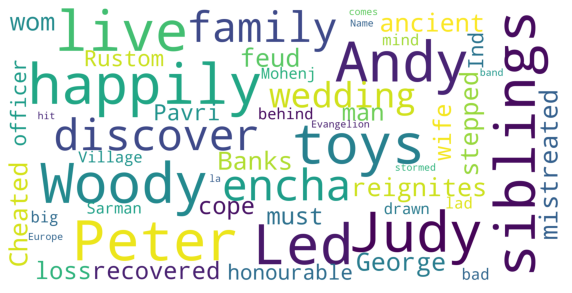

In [150]:
#Elaboration d'un nuage de mot pour les titres
def show_wordcloud(pop_gen, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(pop_gen))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
#nuage de mot pour les titres     
show_wordcloud(dataNLP['overview'])

### Genres

In [151]:
dataNLP['genres']

0       [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1       [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2       [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                          [{'id': 35, 'name': 'Comedy'}]
                              ...                        
9094                        [{'id': 18, 'name': 'Drama'}]
9095    [{'id': 53, 'name': 'Thriller'}, {'id': 10749,...
9096    [{'id': 12, 'name': 'Adventure'}, {'id': 18, '...
9097    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
9098    [{'id': 99, 'name': 'Documentary'}, {'id': 104...
Name: genres, Length: 9099, dtype: object

Nous souhaitons seulement garder les genres ('Animation', 'Adeventure', ...)

In [152]:
dataNLP['genres'] = dataNLP['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s = dataNLP.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [153]:
dataNLP['genres']

0                             [Animation, Comedy, Family]
1                            [Adventure, Fantasy, Family]
2                                       [Romance, Comedy]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9094                                              [Drama]
9095                                  [Thriller, Romance]
9096                 [Adventure, Drama, History, Romance]
9097    [Action, Adventure, Drama, Horror, Science Fic...
9098                                 [Documentary, Music]
Name: genres, Length: 9099, dtype: object

Le premier film de notre base est un film d'Animation, une comédie et un film familial

In [154]:
data_genre = dataNLP.drop('genres', axis=1).join(s) #Si un film a 3 genres, alors il y aura 3 ligne avec un genre par ligne 
data_genre['genre'].value_counts().shape[0]

20

In [58]:
data_genre

,tmdbId,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,spoken_languages,title,movieId,imdbId,genre
0,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,1,114709,Animation
0,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,1,114709,Comedy
0,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,1,114709,Family
1,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,2,113497,Adventure
1,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,2,113497,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9097,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.285519,"[{'name': 'Cine Bazar', 'id': 5896}, {'name': ...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2016-07-29,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Shin Godzilla,163056,4262980,Drama
9097,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.285519,"[{'name': 'Cine Bazar', 'id': 5896}, {'name': ...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2016-07-29,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Shin Godzilla,163056,4262980,Horror
9097,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.285519,"[{'name': 'Cine Bazar', 'id': 5896}, {'name': ...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2016-07-29,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Shin Godzilla,163056,4262980,Science Fiction
9098,391698,tt2531318,en,The Beatles: Eight Days a Week - The Touring Y...,"The band stormed Europe in 1963, and, in 1964,...",7.078301,"[{'name': 'Imagine Entertainment', 'id': 23}, ...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2016-09-15,"[{'iso_639_1': 'en', 'name': 'English'}]",The Beatles: Eight Days a Week - The Touring Y...,163949,2531318,Documentary


In [59]:
pop_gen = pd.DataFrame(data_genre['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'title']
pop_gen.head(10)

,genre,title
0,Drama,4659
1,Comedy,3379
2,Thriller,2019
3,Romance,1852
4,Action,1755
5,Crime,1257
6,Adventure,1201
7,Horror,918
8,Science Fiction,862
9,Family,861


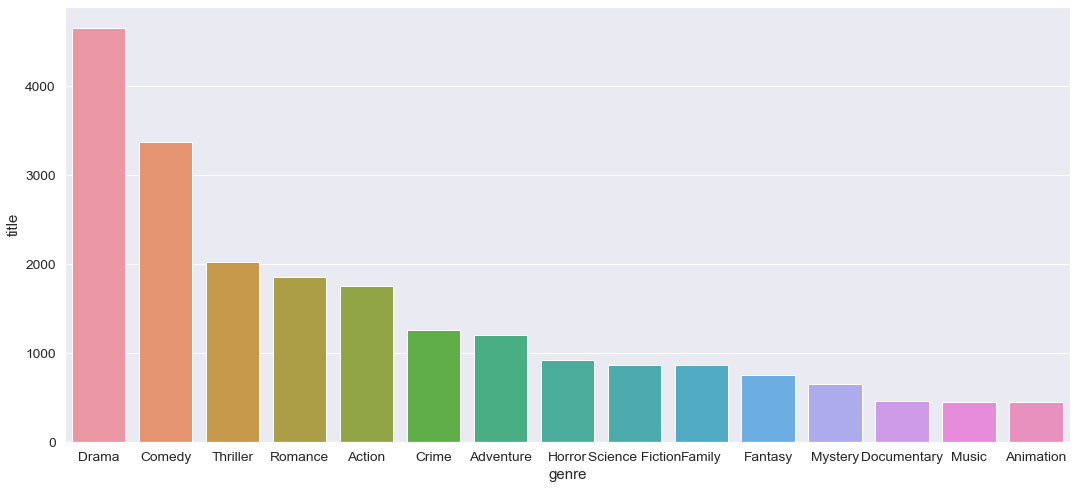

In [60]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='title', data=pop_gen.head(15))
plt.show()

Sur les 20 genres de films, la majotiré sont des drames (près de 4800 films), suivi de comedie et thriller. 

## II. Les systèmes de recommandation de filtrage basé sur le contenu

#### Pre-traitement de texte

Le prétraitement de texte est une étape important en NLP. Cette étape permet de transformer le texte afin que les algorithme de ML soient plus performant.

Pour se faire, nous devons : 
    - tout mettre en minuscule
    - supprimer la ponctuation
    - transformer les phrases en liste de mots (tokenize)
    - supprimer les stop words ("ne", "la", "le", ...)
    - Stemming/Lemmatization
    - On transforme la liste en phrase (inverse tokenize)

Nous allons mettre en place notre système de recommandation de filtrage basé sur le contenu grâce au résumé du film (overview), au genre (genres). 

In [155]:
dataNLP['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [156]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 

lemmatizer = WordNetLemmatizer() 
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'} 
def preprocess_sentences(text): 
  text = text.lower() 
  temp_sent =[] 
  words = nltk.word_tokenize(text) #suppression de la ponctuation
  tags = nltk.pos_tag(words) 
  for i, word in enumerate(words): 
      if tags[i][1] in VERB_CODES:  
          lemmatized = lemmatizer.lemmatize(word, 'v') 
      else: 
          lemmatized = lemmatizer.lemmatize(word) 
      if lemmatized not in stop_words and lemmatized.isalpha(): 
          temp_sent.append(lemmatized) 
          
  #on remplace les "n't" par 'not' ect
  finalsent = ' '.join(temp_sent) 
  finalsent = finalsent.replace("n't", " not") 
  finalsent = finalsent.replace("'m", " am") 
  finalsent = finalsent.replace("'s", " is") 
  finalsent = finalsent.replace("'re", " are") 
  finalsent = finalsent.replace("'ll", " will") 
  finalsent = finalsent.replace("'ve", " have") 
  finalsent = finalsent.replace("'d", " would") 
  return finalsent 
  
dataNLP["resume"]= dataNLP["overview"].apply(preprocess_sentences) 
dataNLP.head() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amale\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,genres,tmdbId,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,spoken_languages,title,movieId,imdbId,resume
0,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,1,114709,lead woody andy toy live happily room andy bir...
1,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,2,113497,sibling judy peter discover enchant board game...
2,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,3,113228,family wedding reignite ancient feud neighbor ...
3,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,4,114885,cheat mistreat step woman hold breath wait elu...
4,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5,113041,george bank recover daughter wedding receive n...


### TF - IDF

A présent, nous allons analyser l'importance d'un mot grâce à la méthode TF-IDF. 

In [157]:
# Vectorizing pre-processed movie plots using TF-IDF 
tfidfvec = TfidfVectorizer() 
tfidf_title = tfidfvec.fit_transform((dataNLP["resume"])) 

tfidf_title.shape

(9099, 24125)

In [65]:
tfidfvec.get_feature_names()[5000:5010]

['cyberhacker',
 'cybernetically',
 'cybernetics',
 'cyberpunk',
 'cybersuit',
 'cybertronics',
 'cybil',
 'cyborg',
 'cycle',
 'cycling']

### Mesure de la similarité

Nous avons, au total, 24 125 vocabulaires/mots différents dans notre dataset.
A présent, nous allons programmer un score de similarite. Il existe plusieurs metriques : manhattan, euclidien, Pearson... Nous allons utiliser la mesure cosinus. 

La similarité cosinus (ou mesure cosinus) permet de calculer la similarité entre deux vecteurs à n dimensions en déterminant le cosinus de l'angle entre eux. Cette métrique est fréquemment utilisée en fouille de textes.

Mathématiquement, on le définit ainsi : 

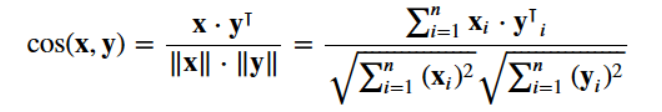

In [66]:
# Mesure cosinus entre les vecteurs de mot
from sklearn.metrics.pairwise import cosine_similarity 
cos_similarite = cosine_similarity(tfidf_title, tfidf_title) 

cos_similarite.shape

(9099, 9099)

In [67]:
cos_similarite[1]

array([0.01847077, 1.        , 0.01938499, ..., 0.00380492, 0.0069429 ,
       0.0126216 ])

Notre objectif est de définir une fonction qui prend un titre de film comme entrée et qui nous sort une liste de 10 films similaires (en fonction du résumé). 

In [210]:
#Construction d'un mécanisme pour identifier l'index d'un film compte tenu de son titre
indices = pd.Series(dataNLP.index, index=dataNLP['title']).drop_duplicates()

In [211]:
def recommandation(title, cos_similarite=cos_similarite):
    #On met tt les titres en minuscule afin de pouvoir trouver la recommandation de "toy story" et pas forcément 'Toy Story'
    movies_lowercase = list(map(lambda x:x.lower(),indices.index))
    idx = movies_lowercase.index(title.lower())
    #Obtenir les scores de similarite de tous les films avec le film
    scores_similarite = list(enumerate(cos_similarite[idx]))
    # Trier en fonction du score 
    scores_similarite = sorted(scores_similarite, key=lambda x: x[1], reverse=True)
    # Garder le score des 10 premiers films
    scores_similarite = scores_similarite[1:11]
    # Avoir l'indice du film pour avoir le titre
    indices_film = [i[0] for i in scores_similarite]
    return dataNLP['title'].iloc[indices_film]

In [212]:
recommandation("toy story")

7545               Toy Story 3
2504               Toy Story 2
6201    The 40 Year Old Virgin
6563    For Your Consideration
2549           Man on the Moon
892      Rebel Without a Cause
437                     Malice
1601                 Condorman
6636              Factory Girl
5147            Africa Screams
Name: title, dtype: object

## Word2vec 

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
clean_sentences = [' '.join(sentence) for sentence in texts]

In [233]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(lee_corpus_list, vector_size=24, epochs=100)


NameError: name 'lee_corpus_list' is not defined

In [83]:
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from gensim import corpora, models, similarities

In [257]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english") # Choose a language

#On transforme les résumé en list de mots 
doc = list(dataNLP['resume'])
texte = i.split(' ')
texts = [[stemmer.stem(word) for word in document.lower().split() if (word not in stop_words)]
for document in doc]

AttributeError: 'list' object has no attribute 'split'

Nous créeons un dicctionnaire pour enregistrer chaque vocabulaire

In [111]:
dicco = corpora.Dictionary(texts)

In [216]:
vocabulary_size = list(itertools.islice(dicco.token2id.items(),0,20))
vocabulary_size

[('afraid', 0),
 ('andi', 1),
 ('asid', 2),
 ('birthday', 3),
 ('bring', 4),
 ('buzz', 5),
 ('circumst', 6),
 ('differ', 7),
 ('duo', 8),
 ('eventu', 9),
 ('happili', 10),
 ('heart', 11),
 ('lead', 12),
 ('learn', 13),
 ('lightyear', 14),
 ('live', 15),
 ('lose', 16),
 ('onto', 17),
 ('owner', 18),
 ('place', 19)]

In [107]:
voc = dict(vocabulary_size)
voc

{'afraid': 0,
 'andi': 1,
 'asid': 2,
 'birthday': 3,
 'bring': 4,
 'buzz': 5,
 'circumst': 6,
 'differ': 7,
 'duo': 8,
 'eventu': 9,
 'happili': 10,
 'heart': 11,
 'lead': 12,
 'learn': 13,
 'lightyear': 14,
 'live': 15,
 'lose': 16,
 'onto': 17,
 'owner': 18,
 'place': 19}

Nous allons vectorier notre phrase. 

In [90]:
corpus = [dicco.doc2bow(text) for text in texts]
print(corpus[2][:20])

[(46, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 2), (76, 1), (77, 1)]


In [218]:
print(corpus[1])

[(15, 1), (22, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]


Le vecteur (46,1) correspond au mot avec l'id = 46 (titre), qui apparait une fois dans le corpus [2]. Soit le résumé numéro 3.

In [115]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      corpus, 
      vocabulary_size=len(vocabulary_size),
      window_size=window_size,
      negative_samples=0)
print(len(positive_skip_grams))

36382


In [104]:
len(vocabulary_size)

20

In [250]:
dicco[4]

'bring'

In [117]:
import gzip
import gensim 
import logging

In [137]:
 model = gensim.models.Word2Vec(
        texts,
        size=300,
        window=10,
        min_count=2,
        workers=10,
        iter=10)

In [241]:
#On affiche les 10 mots les plus similaires à "afraid"
w1 = "sad"
model.wv.most_similar (positive=w1)

[('plus', 0.9975538849830627),
 ('orphanag', 0.9974834322929382),
 ('hate', 0.9973935484886169),
 ('thought', 0.9973293542861938),
 ('recogn', 0.99732506275177),
 ('except', 0.9973244071006775),
 ('revers', 0.9972895979881287),
 ('elisabeth', 0.9972178339958191),
 ('antic', 0.9971222281455994),
 ('leo', 0.9971066117286682)]